In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score
pd.options.display.float_format = '{:.3f}'.format

1. Получить данные.  
2. Провести первичный анализ.  
    a. Проверить данные на пропуски. Удалить в случае обнаружения.  
    b. \*Нормализовать один из признаков.  
3. Разделить выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.  
4. Обучить модель регрессии на обучающем множестве.  
5. Для тестового множества предсказать целевую переменную и сравнить с истинным значением, посчитав точность предсказания модели. Использовать встроенную функцию `score`. 
6. Обучить дерево решений на обучающем множестве.  
    a. Повторить п. 5 для полученной модели.  
    b. Визуализировать часть дерева решений.
7. Оптимизировать глубину дерева (max_depth). \*Оптимизировать ещё один параметр модели на выбор.  
    a. Повторить п. 5 для полученной модели.  
8. Сформулировать выводы.  

#### 1. Загружаем данные

In [2]:
california_housing = fetch_california_housing(as_frame=True)

In [3]:
print(fetch_california_housing().DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
df = california_housing.frame

In [5]:
df.head(7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.325,41.000,6.984,1.024,322.000,2.556,37.880,-122.230,4.526
1,8.301,21.000,6.238,0.972,2401.000,2.110,37.860,-122.220,3.585
2,7.257,52.000,8.288,1.073,496.000,2.802,37.850,-122.240,3.521
3,5.643,52.000,5.817,1.073,558.000,2.548,37.850,-122.250,3.413
4,3.846,52.000,6.282,1.081,565.000,2.181,37.850,-122.250,3.422
5,4.037,52.000,4.762,1.104,413.000,2.140,37.850,-122.250,2.697
6,3.659,52.000,4.932,0.951,1094.000,2.128,37.840,-122.250,2.992


#### 2. Пропуски

In [6]:
pd.concat([df.isnull().sum().rename('cnt'), round((df.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
MedInc,0,0.000
HouseAge,0,0.000
AveRooms,0,0.000
AveBedrms,0,0.000
Population,0,0.000
AveOccup,0,0.000
Latitude,0,0.000
Longitude,0,0.000
MedHouseVal,0,0.000


Пропусков нет. Но это и было указано в описании датасета.

#### \*Нормализация  
$$ x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}} $$

In [7]:
def get_normalize(df, cols):
    df = df.copy()
    for each in cols:
        arr = np.array(df[each])
        df[each] = np.divide((arr - arr.min()),(arr.max() - arr.min()))
    return df

In [8]:
df = get_normalize(df, ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])

In [9]:
df.head(7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0.540,0.784,0.044,0.020,0.009,0.001,0.567,0.211,4.526
1,0.538,0.392,0.038,0.019,0.067,0.001,0.565,0.212,3.585
2,0.466,1.000,0.053,0.022,0.014,0.002,0.564,0.210,3.521
3,0.355,1.000,0.035,0.022,0.016,0.001,0.564,0.209,3.413
4,0.231,1.000,0.039,0.022,0.016,0.001,0.564,0.209,3.422
5,0.244,1.000,0.028,0.023,0.011,0.001,0.564,0.209,2.697
6,0.218,1.000,0.029,0.018,0.031,0.001,0.563,0.209,2.992


#### 3,4,5 Разделение выборки, обучение регрессии, расчет score

In [10]:
def get_score(df, target, random_seed=42, model=None, title=''):
    if model is None:
        model = LinearRegression()
    
    y = df[target]
    X = df.drop([target], axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) 

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    res_train = model.score(X_train, y_train)
    res_test = model.score(X_test, y_test)
    metrix = {}
    metrix['score_train'] = res_train
    metrix['score_test'] = res_test
    res = pd.DataFrame.from_dict(metrix, orient='index', columns=[title])
    return res

In [11]:
res = pd.DataFrame()

In [12]:
res_0 = get_score(
    df, 
    'MedHouseVal', 
    title='Logreg')
res = pd.concat([res, res_0], axis=1)
res.T

,score_train,score_test
Logreg,0.613,0.576


#### 6. Обучение дерева решений и визуализации

In [13]:
res_1 = get_score(
    df, 
    'MedHouseVal', 
    model=DecisionTreeRegressor(random_state=42), 
    title='DTR_md_inf')
res = pd.concat([res, res_1], axis=1)
res.T

,score_train,score_test
Logreg,0.613,0.576
DTR_md_inf,1.000,0.618


Очевидно что если модель __дерева решений__ не остановить она переучивается, но и на тестовой выборке метрика лучше чем у __линейной регрессии__

In [14]:
y = df['MedHouseVal']
X = df.drop(['MedHouseVal'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
regr = DecisionTreeRegressor(
    max_depth=3, 
    random_state=42)
model = regr.fit(X_train.values, y_train)
y_pred = model.predict(X_train.values)

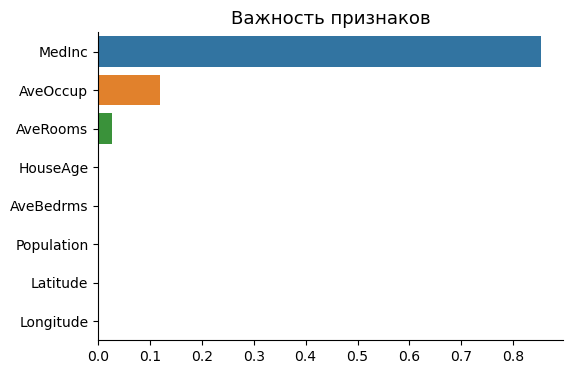

In [15]:
fig = plt.figure(figsize=(6,4))
feature_imp = pd.Series(regr.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title(f'Важность признаков', size=13)
plt.xlabel('', size=8)
sns.despine()
plt.ylabel('', size=8)
plt.show()

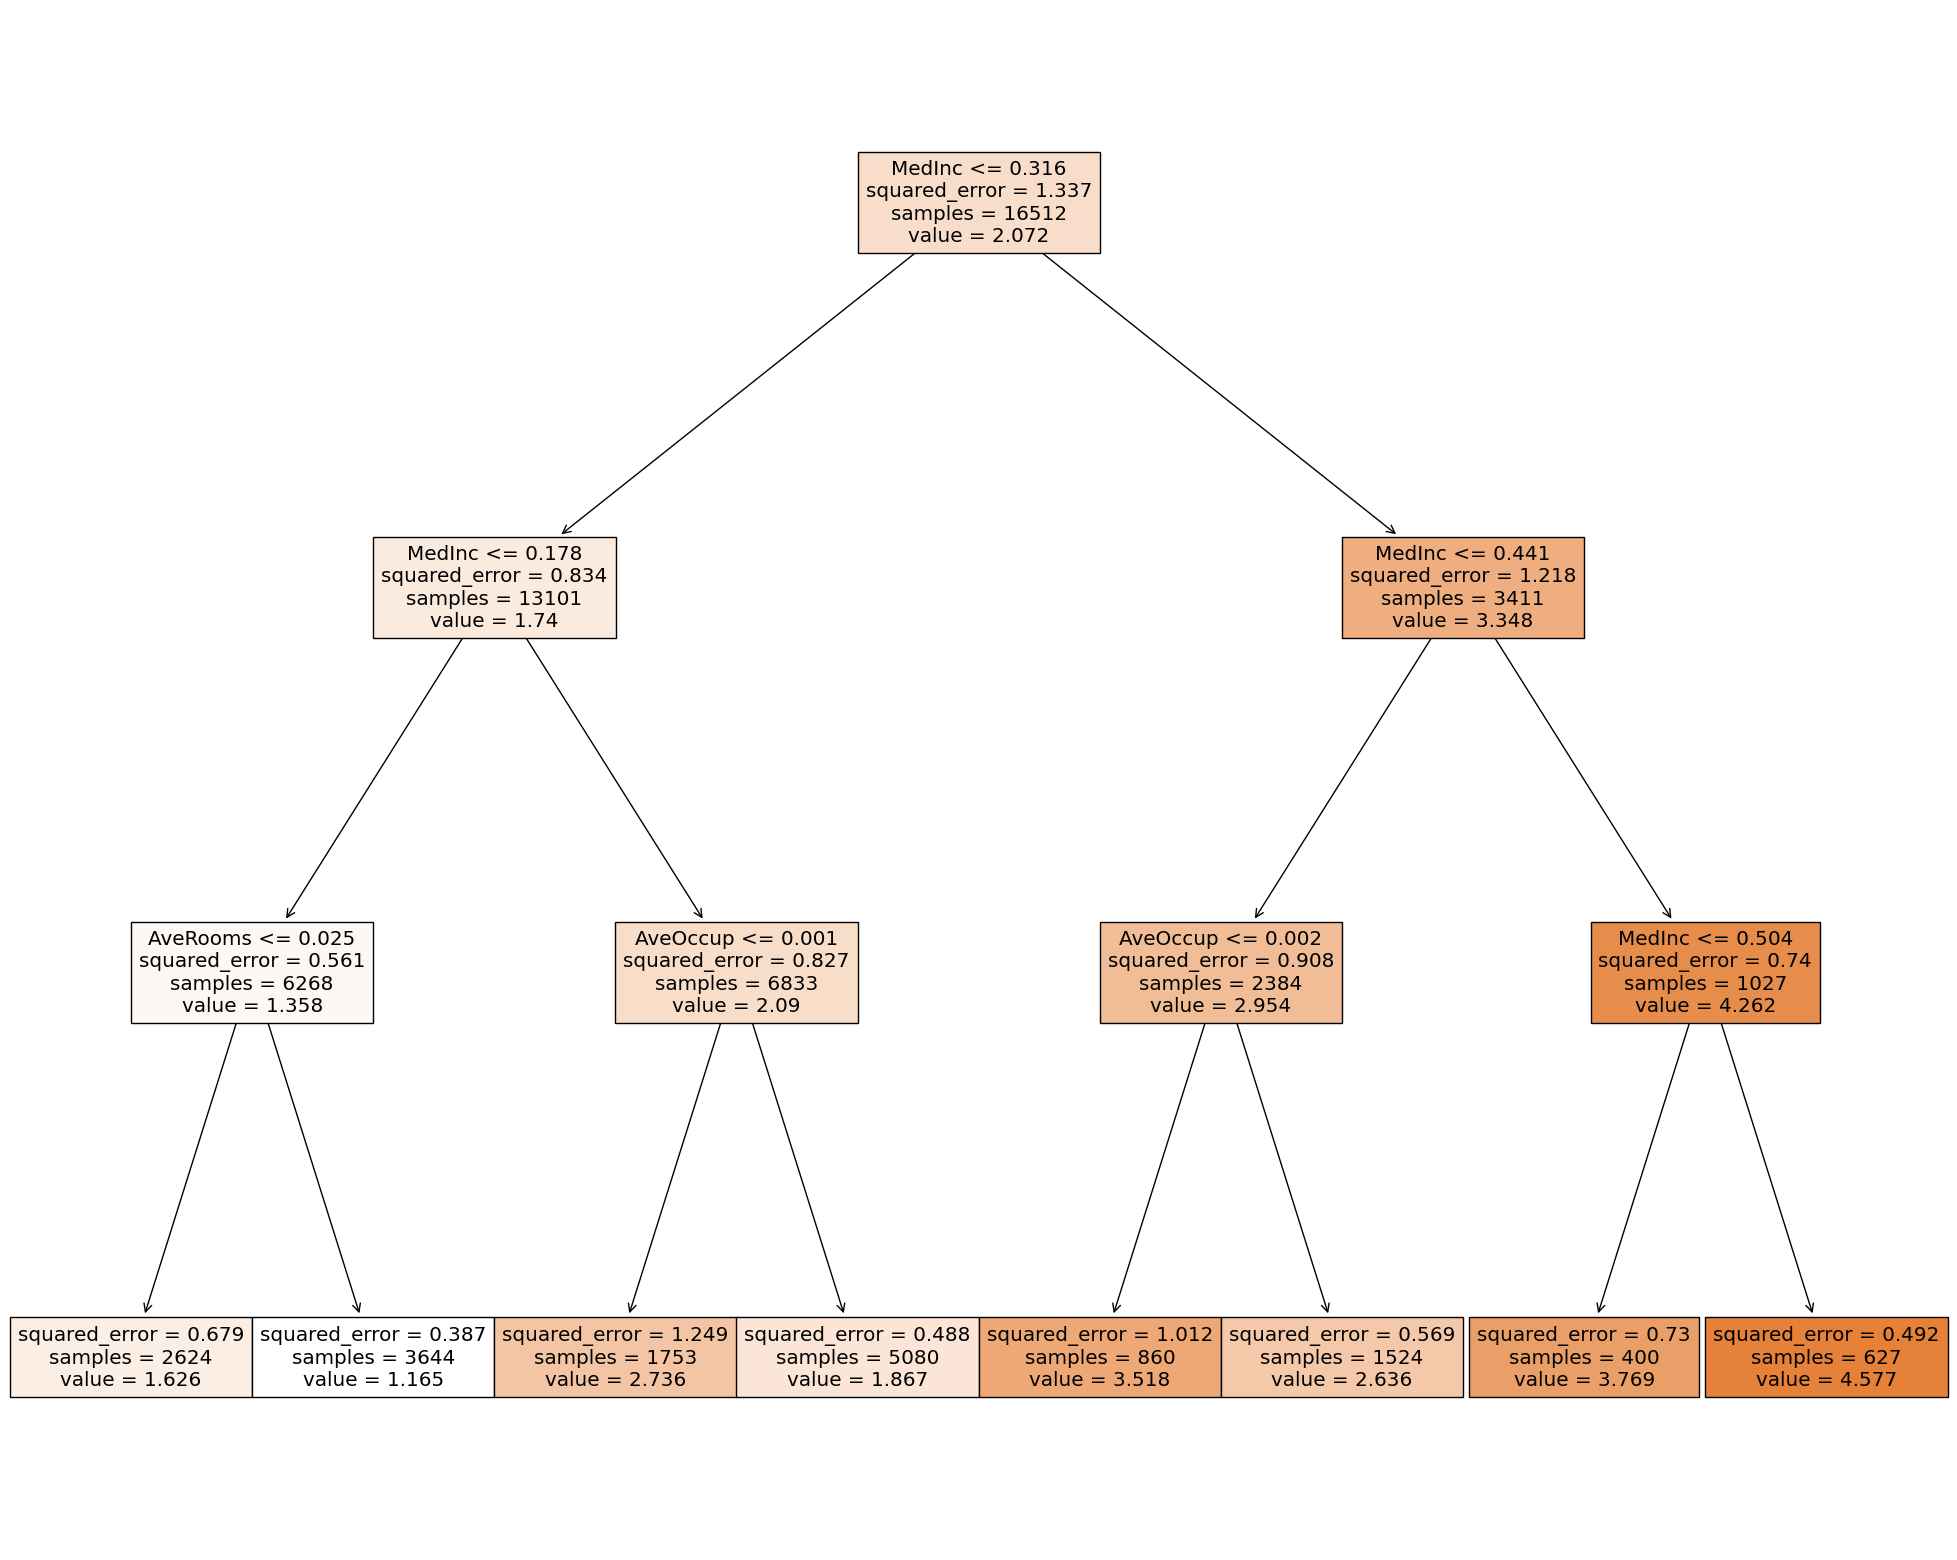

In [16]:
fig = plt.figure(figsize=(25,20))
viz1 = plot_tree(regr, feature_names=X.columns, filled=True)

In [17]:
print(f'Ср знач ЦП: {y_train.mean()}')
pd.Series(y_pred, name='cnt').value_counts()

Ср знач ЦП: 2.0719469373788537


1.867    5080
1.165    3644
1.626    2624
2.736    1753
2.636    1524
3.518     860
4.577     627
3.769     400
Name: cnt, dtype: int64

Визуализации демонстрируют следующее: 
1. По важности признаков, к признаку __MedInc__ задается больше всего вопросов, затем __Aveoccup__, затем __AveRooms__
2. На первом узле дерево определяет целевую переменную как среднее, вычисляет ошибку, и вопросом делит выборку на отсечке 0.316 нормализованного __MedInc__
3. Далее две подвыборки __MedInc__ по такому же принципу (со своими средними значениями целевой переменной (ЦП) и рассчитанной ошибкой) делятся еще на две - итого получается четыре подвыборки
4. На узлах этого уровня более важными становятся вопросы к признакам __Aveoccup__, __AveRooms__ и все еще __MedInc__. Четыре подвыборки делятся еще на две - становится восемь подвыборок со своими средними значениями ЦП и ошибкой. 
5. Так как мы установили ограничение до 3 уровней дерева, модель на этом останавливается
6. В итоге мы имеем восемь вариантов предсказаний цен для конкретного числа объектов. Это подтверждается счетчиком возможных вариантов предсказанных ЦП модели. 
7. Если бы мы не остановили модель она бы подогнала предсказания для всех объектов. 

#### 7. Оптимизация параметров

In [18]:
for n in range(1, 17, 2):
    res_2 = get_score(
        df, 
        'MedHouseVal', 
        model=DecisionTreeRegressor(
            max_depth=n,
            random_state=42), 
        title=f'DTR_md{n}')
    res = pd.concat([res, res_2], axis=1)
res.T

,score_train,score_test
Logreg,0.613,0.576
DTR_md_inf,1.000,0.618
DTR_md1,0.317,0.280
DTR_md3,0.538,0.510
DTR_md5,0.638,0.600
DTR_md7,0.717,0.652
DTR_md9,0.800,0.684
DTR_md11,0.871,0.677
DTR_md13,0.924,0.664
DTR_md15,0.961,0.647


In [19]:
for n in range(1, 30, 2):
    res_3 = get_score(
        df, 
        'MedHouseVal', 
        model=DecisionTreeRegressor(
            max_depth=9, 
            min_samples_leaf=n, 
            random_state=42), 
        title=f'DTR_md9_sl{n}')
    res = pd.concat([res, res_3], axis=1)
res.T

,score_train,score_test
Logreg,0.613,0.576
DTR_md_inf,1.000,0.618
DTR_md1,0.317,0.280
DTR_md3,0.538,0.510
DTR_md5,0.638,0.600
DTR_md7,0.717,0.652
DTR_md9,0.800,0.684
DTR_md11,0.871,0.677
DTR_md13,0.924,0.664
DTR_md15,0.961,0.647


In [20]:
res.T.reset_index()[res.T.reset_index()['score_test'] \
                        == res.T.reset_index()['score_test'].max()]

,index,score_train,score_test
20,DTR_md9_sl21,0.770,0.703


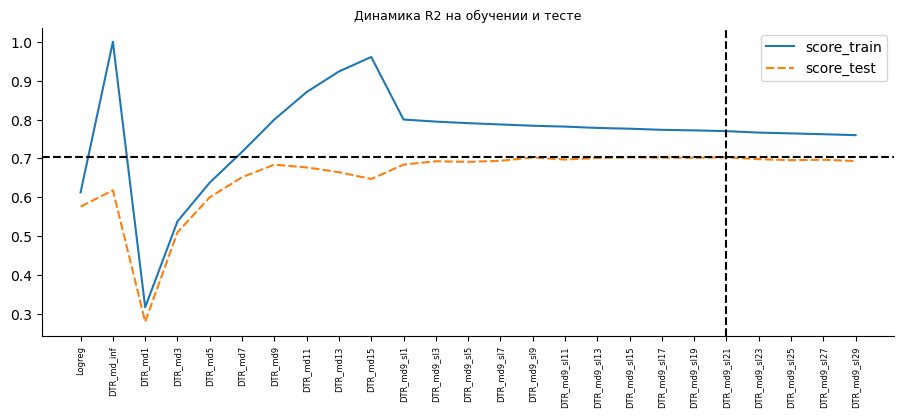

In [21]:
fig = plt.figure(figsize=(11,4))
sns.lineplot(data=res.T)
plt.axhline(y=res.T['score_test'].max(), color='black', linestyle='--')
plt.axvline(x = (
    res.T.reset_index()[res.T.reset_index()['score_test'] \
                        == res.T.reset_index()['score_test'].max()].index
)[0], color='black', linestyle='--')
plt.title(f'Динамика R2 на обучении и тесте', size=9)
plt.xticks(fontsize=6, rotation=90)
sns.despine()
plt.show()

Перебор параметров определил что на тестовой выборке уровень переобучения и метрика лучше всего при глубине 9 на 21 листе. 
На этом датасете, даже учитывая переобучение, модель дерева решений при таких параметрах однозначно лучше линейной регрессии. К тому же переобучению подвержены обе модели.